In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

### Analyze direct QA

In [243]:
def load_qa_results(filters=None):
    df = pd.read_json("results/qa_results.jsonl", lines=True)
    
    config_df = pd.json_normalize(df['config'])
    config_df.columns = ['config_' + col for col in config_df.columns]
    df = pd.concat([df, config_df], axis=1)

    df['options_str'] = df['options'].apply(str)

    df = df.sort_values('datetime', ascending=False).drop_duplicates(
        subset=['question', 'options_str', 'config_model_name'], keep='first')

    df['parsed_answer'] = df['parsed_model_response'].apply(lambda x: x.get('answer'))
    df = df[df['parsed_answer'].notna()]

    df['is_correct'] = df['parsed_answer'] == df['correct_idx']
    
    if filters:
        for col, val in filters.items():
            if val is None:
                df = df[df[col].isna()]
            else:
                df = df[df[col] == val]
    
    return df

In [244]:
filters = {
    # MODEL OPTIONS
    'config_model_name': "x-ai/grok-4-fast",
    # 'config_model_name': "openai/gpt-4o-mini",

    # DATASET OPTIONS
    # 'config_dataset_name': "Idavidrein/gpqa",
    # 'config_dataset_subset': "gpqa_diamond",
    # 'config_dataset_split': "train",

    'config_dataset_name': "TIGER-Lab/MMLU-Pro",
    'config_dataset_subset': None,
    'config_dataset_split': "test",

    # OTHER OPTIONS
    'config_random_seed': 42,
    'config_num_choices': 4,
}


In [245]:
df = load_qa_results(filters)

valid_df = df[df['parsed_answer'].notna()]
accuracy = valid_df['is_correct'].mean()
correct_count = valid_df['is_correct'].sum()
total_count = len(valid_df)

print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct_count}/{total_count}")

Accuracy: 92.00%
Correct: 92/100


### Analyze debate

In [198]:
def load_debate_results(run_id):
    # Load the debate results
    results_file = f"results/debate/{run_id}.jsonl"

    df = pd.read_json(results_file, lines=True)

    config_df = pd.json_normalize(df['config'])
    config_df.columns = ['config_' + col for col in config_df.columns]
    df = pd.concat([df, config_df], axis=1)
    
    df['options_str'] = df['options'].apply(str)

    # Add is correct field
    df['parsed_answer'] = df['judge_verdict'].apply(lambda x: x.get('parsed', {}).get('answer', {}))
    df = df[df['parsed_answer'].notna()]
    df['is_correct'] =  df['parsed_answer'] == df['correct_idx']

    return df

In [233]:
# run_id = 'ey2anfr'
run_id = 'usizxo3'

df = load_debate_results(run_id)

valid_df = df[df['parsed_answer'].notna()]
accuracy = valid_df['is_correct'].mean()
correct_count = valid_df['is_correct'].sum()
total_count = len(valid_df)

print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct_count}/{total_count}")

Accuracy: 50.00%
Correct: 1/2


### Compare QA and Debate

In [240]:
def load_debate_with_qa(run_id):
    qa_df = load_qa_results(filters=None)
    qa_df = qa_df[['question', 'options_str', 'config_model_name', 'is_correct']]

    debate_df = load_debate_results(run_id)

    merged_df = debate_df.merge(
        qa_df,
        left_on=['question', 'options_str', 'config_judge_model'],
        right_on=['question', 'options_str', 'config_model_name'],
        how='left', suffixes=('', '_judge_qa'))

    merged_df = merged_df.merge(
        qa_df,
        left_on=['question', 'options_str', 'config_debater_model'],
        right_on=['question', 'options_str', 'config_model_name'],
        how='left', suffixes=('', '_debater_qa'))

    # only keep rows where all is_correct fields are not None
    merged_df = merged_df[merged_df['is_correct'].notna() & merged_df['is_correct_judge_qa'].notna() & merged_df['is_correct_debater_qa'].notna()]

    return merged_df

In [241]:
run_id = 'usizxo3'

merged_df = load_debate_with_qa(run_id)

judge_qa = merged_df["is_correct_judge_qa"].mean().round(2) 
debater_qa = merged_df["is_correct_debater_qa"].mean().round(2)
debate_verdict = merged_df["is_correct"].mean().round(2)

print(f'Judge QA: {judge_qa} ({merged_df["is_correct_judge_qa"].sum()}/{merged_df["is_correct_judge_qa"].count()})')
print(f'Debater QA: {debater_qa} ({merged_df["is_correct_debater_qa"].sum()}/{merged_df["is_correct_debater_qa"].count()})')
print(f'Debate Verdict: {debate_verdict} ({merged_df["is_correct"].sum()}/{merged_df["is_correct"].count()})')

Judge QA: 1.0 (2/2)
Debater QA: 1.0 (2/2)
Debate Verdict: 0.5 (1/2)


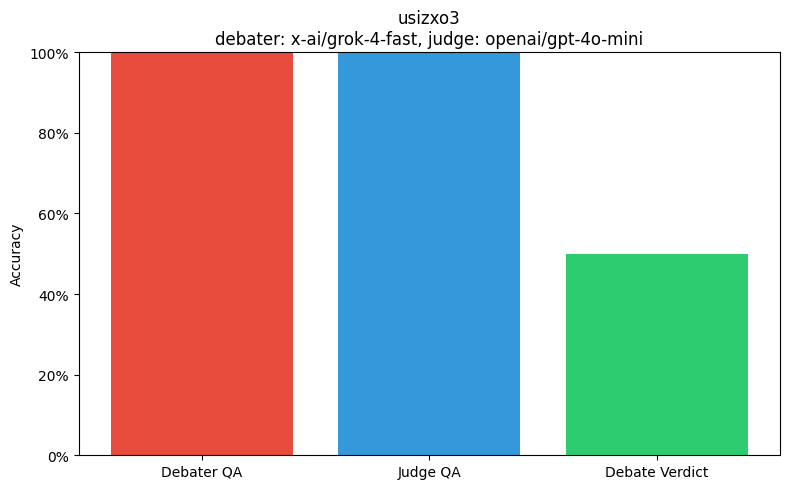

In [242]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Debater QA', 'Judge QA', 'Debate Verdict'], [debater_qa, judge_qa, debate_verdict], color=['#e74c3c', '#3498db', '#2ecc71'])
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
debater_model = merged_df['config_debater_model'].iloc[0]
judge_model = merged_df['config_judge_model'].iloc[0]
plt.title(f'{run_id}\ndebater: {debater_model}, judge: {judge_model}')
plt.tight_layout()
plt.show()

### Analyze token usage in the debate run

In [260]:
run_id = 's17e3id'

debate_df = load_debate_results(run_id)

total_tokens_used_per_debate = []
reasoning_tokens_used_per_debate = []
for i, row in debate_df.iterrows():
    debate_history = row['debate_history']
    total_tokens_used_this_debate, reasoning_tokens_used_this_debate = 0, 0
    for turn in debate_history:
        total_tokens_used_this_debate += turn['token_usage']['total_tokens']
        reasoning_tokens_used_this_debate += turn['token_usage']['completion_tokens_details']['reasoning_tokens']
    total_tokens_used_per_debate.append(total_tokens_used_this_debate)
    reasoning_tokens_used_per_debate.append(reasoning_tokens_used_this_debate)

print(total_tokens_used_per_debate)
print('lo')
print(reasoning_tokens_used_per_debate)


[4252, 3861, 4627, 5088, 4601, 6105, 5138, 5907, 6303, 9606, 9436, 10798, 13006, 16185, 18999, 26467, 47614, 56981]
lo
[1554, 1195, 2024, 1363, 1504, 2701, 2606, 2955, 2297, 6968, 6537, 8140, 9862, 11983, 15872, 23232, 44658, 54178]
